In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import acr
import spikeinterface.extractors as se
import spikeinterface.core as si
import kdephys.units as ku
import pandas as pd
import numpy as np
import acr.info_pipeline as aip
import tdt
import acr.units as au
import matplotlib.pyplot as plt
plt.style.use('acr_plots.mplstyle')
import xarray as xr
import kdephys.xr as kx
import kdephys.hypno as kh
import ecephys.xrsig.core as xrcss
import pandas_flavor as pf
import kdephys.units.methods

/home/kdriessen/miniconda3/envs/acrdev/lib/python3.10/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/home/kdriessen/github_t2/kdephys/kdephys/xr/utils.py:4: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
/home/kdriessen/github_t2/kdephys/kdephys/units/methods.py:9: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'xnote' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def xnote(self, notes=["noisy", "bw"]):


In [2]:
def xcat(ds, recordings, stores=['NNXo', 'NNXr']):
    data = {}
    for store in stores:
        to_concat = []
        for recording in recordings:
            to_concat.append(ds[f'{recording}-{store}'])
        data[store] = xr.concat(to_concat, dim='datetime')
    return data

In [4]:
fp = acr.io.load_xr('ACR_14', ['sdpi-bl', 'sdpi', 'sdpi-post', 'laser1-bl', 'laser1', 'laser1-post1', 'swi-bl', 'swi-sd', 'swi'])

/home/kdriessen/miniconda3/envs/acrdev/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [151]:
spg = kx.spectral.get_spg_from_dataset(fp)
bp = kx.spectral.get_bp_from_dataset(spg)

In [3]:
hyp = {}
hyp['sdpi'] = acr.io.load_hypno('ACR_14', 'sdpi')
hyp['sdpi-bl'] = acr.io.load_hypno('ACR_14', 'sdpi-bl')
hyp['laser1'] = acr.io.load_hypno('ACR_14', 'laser1')
hyp['laser1-bl'] = acr.io.load_hypno('ACR_14', 'laser1-bl')
hyp['swi'] = acr.io.load_hypno('ACR_14', 'swi')
hyp['swi-bl'] = acr.io.load_hypno('ACR_14', 'swi-bl')


In [4]:
d = {}
d['sdpi-r'] = au.single_probe_spike_df('ACR_14', 'sdpi-NNXr')
d['sdpi-o'] = au.single_probe_spike_df('ACR_14', 'sdpi-NNXo')

assigning recordings
assigning datetimes
adding stim info
adding hypno


/home/kdriessen/github_t2/acr/acr/units.py:107: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  states = pd.Series()


assigning recordings
assigning datetimes
adding stim info
adding hypno


/home/kdriessen/github_t2/acr/acr/units.py:107: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  states = pd.Series()


Text(0.0, 1.0, 'SDPI Firing Rate, 60s Rolling Window')

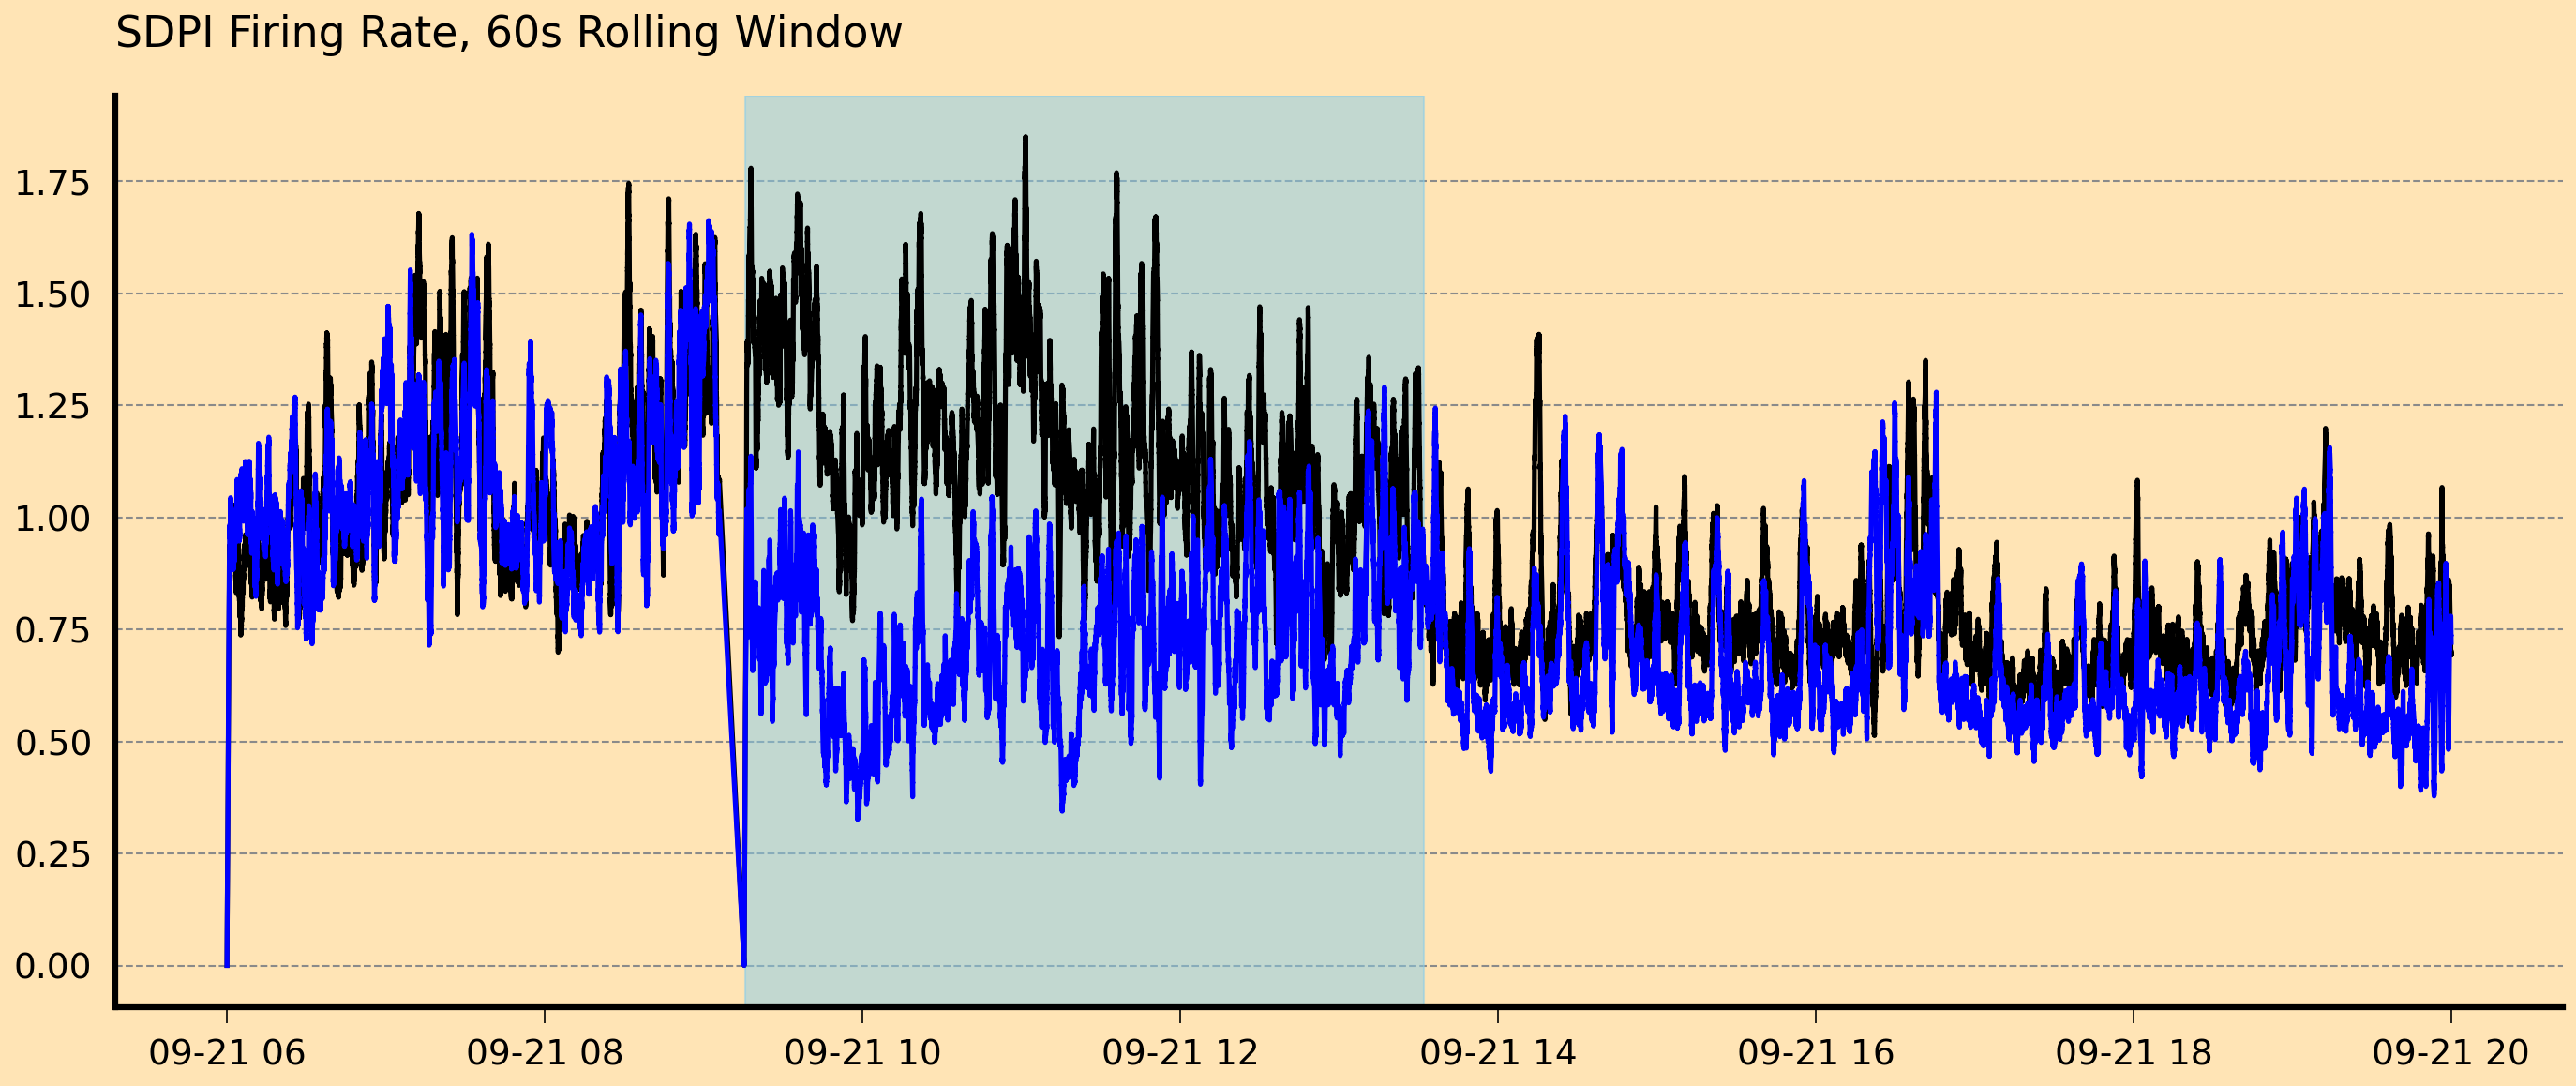

In [17]:
pm = d['sdpi-r'].udf.rec('sdpi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
om = d['sdpi-o'].udf.rec('sdpi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-09-21 6:00:00'
t2 = '2022-09-21 20:00:00'
pdata = d['sdpi-r'].udf.ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/pm
odata = d['sdpi-o'].udf.ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(d['sdpi-r'].udf.ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(d['sdpi-o'].udf.ts(t1, t2).datetime.values, odata, color='blue')
stim_borders = d['sdpi-r'].udf.stim().datetime.values.min(), d['sdpi-r'].udf.stim().datetime.values.max()
ax.axvspan(stim_borders[0], stim_borders[1], color='skyblue', alpha=0.5)
ax.set_title('SDPI Firing Rate, 60s Rolling Window')

In [157]:
sdpi = xcat(bp, ['sdpi-bl', 'sdpi', 'sdpi-post'])
f, ax = plt.subplots(1, 1, figsize=(20, 8))
t1 = '2022-09-21 6:00:00'
t2 = '2022-09-21 23:00:00'
ts = slice(t1, t2)
ax.plot(sdpi['NNXr'].delta.sel(datetime=ts).datetime.values, sdpi['NNXr'].delta.sel(datetime=ts, channel=15), color='k')
ax.set_ylim(0, 1000000)

# SWI - 'Slow Wave Induction'

In [19]:
d['swio'] = au.single_probe_spike_df('ACR_14', 'swi-NNXo', stim=False)
d['swip'] = au.single_probe_spike_df('ACR_14', 'swi-NNXr', stim=False)

assigning recordings
assigning datetimes
adding hypno


/home/kdriessen/github_t2/acr/acr/units.py:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  states = pd.Series()


assigning recordings
assigning datetimes
adding hypno


/home/kdriessen/github_t2/acr/acr/units.py:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  states = pd.Series()


AttributeError: 'DataFrame' object has no attribute 'stim'

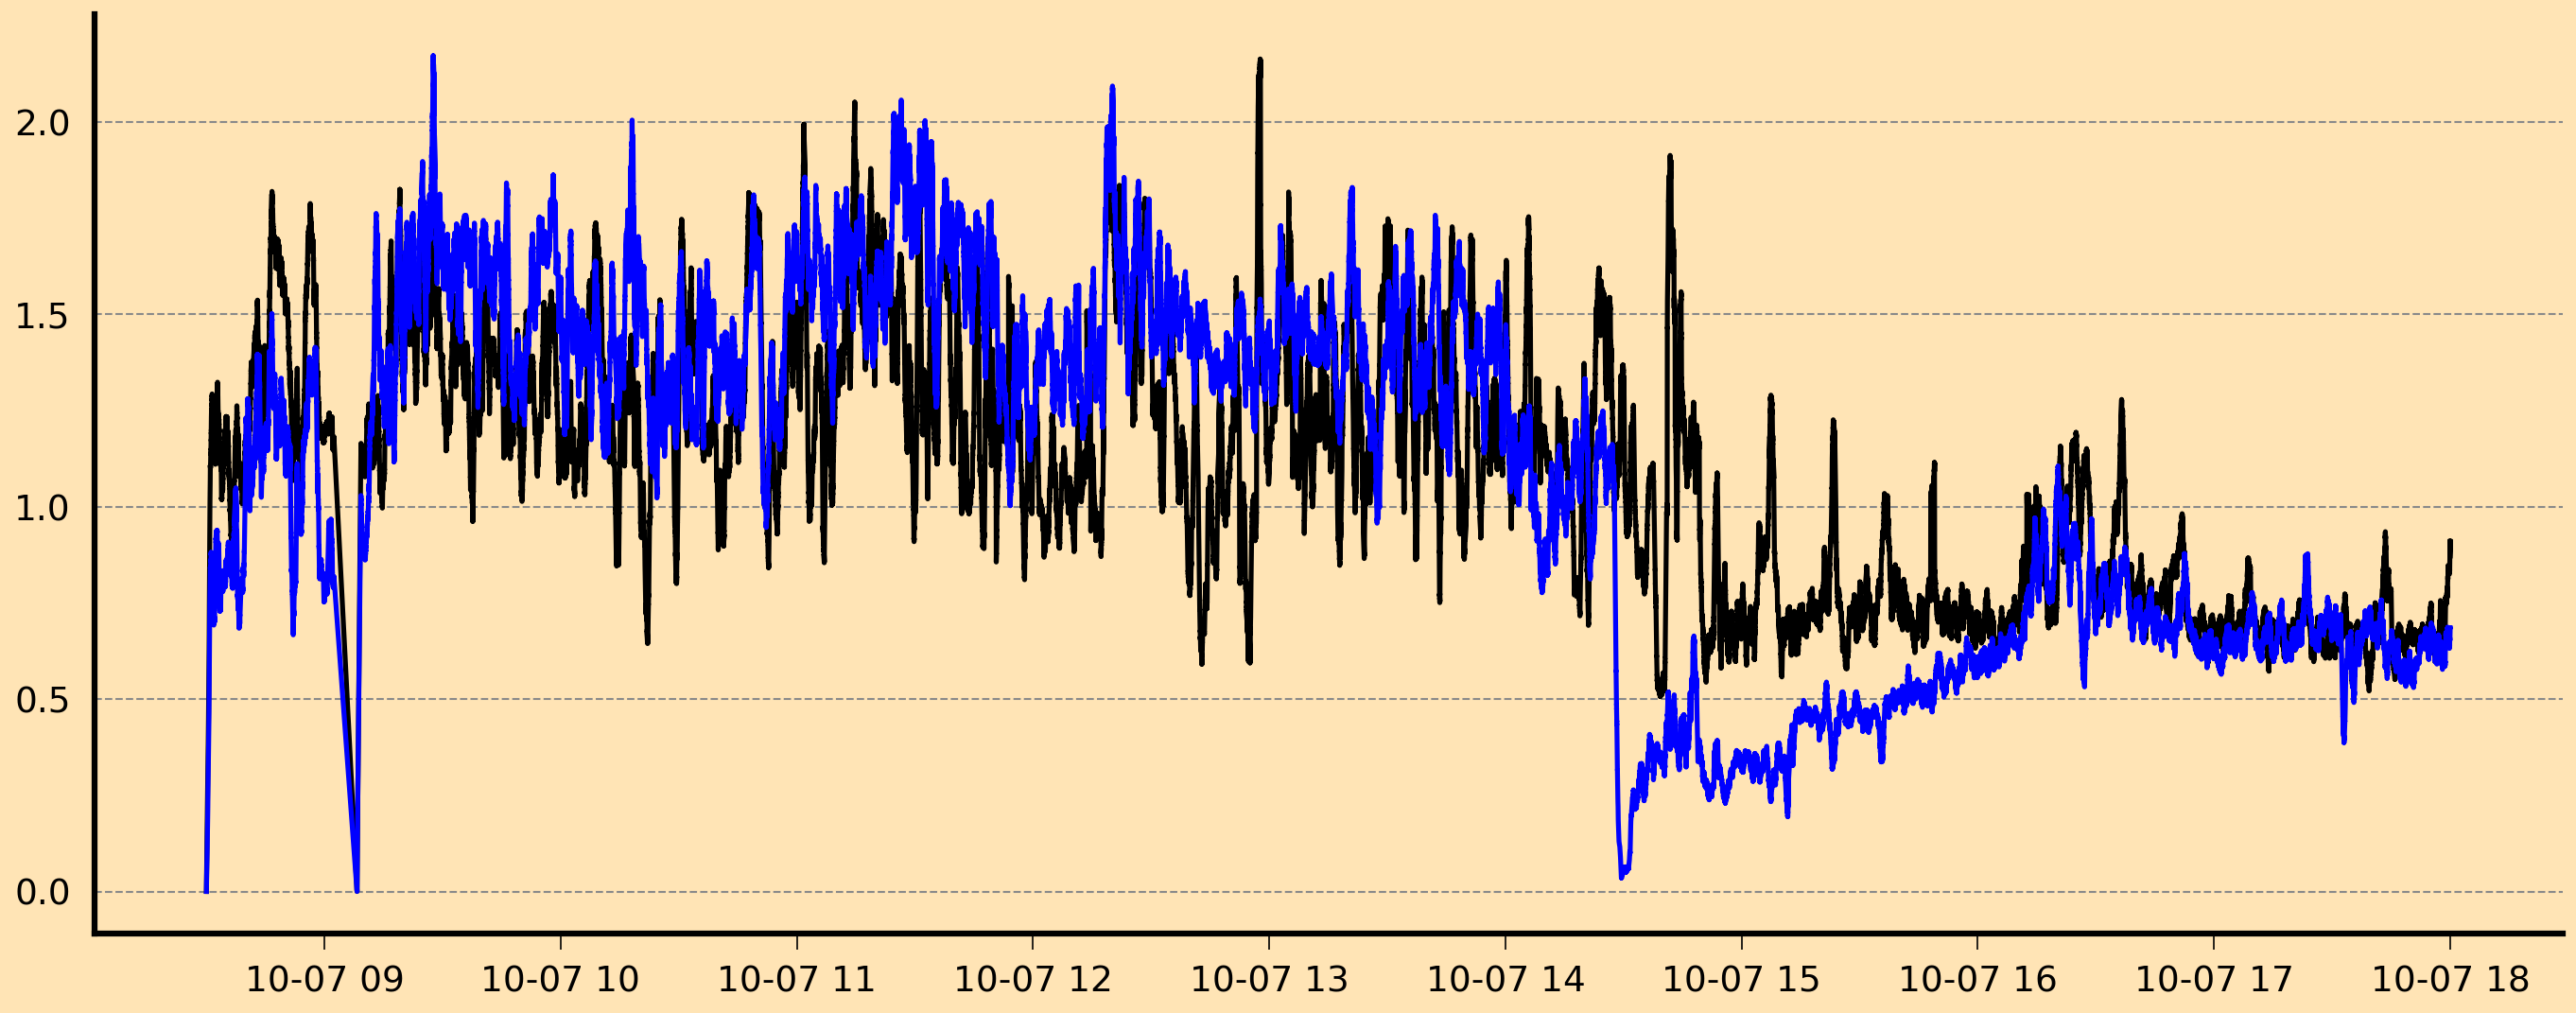

In [78]:
pm = d['swip'].udf.rec('swi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
om = d['swio'].udf.rec('swi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-10-07 08:30:00'
t2 = '2022-10-07 18:00:00'
pdata = d['swip'].udf.ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/pm
odata = d['swio'].udf.ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(d['swip'].udf.ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(d['swio'].udf.ts(t1, t2).datetime.values, odata, color='blue')

stim_borders = d['swio'].udf.stim().datetime.values.min(), d['swio'].udf.stim().datetime.values.max()
ax.axvspan(stim_borders[0], stim_borders[1], color='skyblue', alpha=0.5)

ax.set_title('swi Firing Rate, 60s Rolling Window')

In [179]:
swi = xcat(bp, ['swi-bl', 'swi-sd', 'swi'])

In [184]:
bp['swi-bl-NNXo']

<xarray.DataArray 'delta' ()>
array(72721.14, dtype=float32)

In [72]:
foo = fp['swi-NNXo']
print(foo.datetime.values.min(), foo.datetime.values.max())

2022-10-07T14:06:28.999999000 2022-10-08T10:29:24.741213720


In [74]:
start = pd.to_datetime("2022-10-07T09:00:00")
stop = pd.to_datetime("2022-10-07T10:00:00")

In [77]:
foo.sel(datetime=slice(start, stop))

<xarray.DataArray (datetime: 0, channel: 2)>
array([], shape=(0, 2), dtype=float32)
Coordinates:
    time       (datetime) float64 
    timedelta  (datetime) timedelta64[ns] ...
  * datetime   (datetime) datetime64[ns] 
  * channel    (channel) int64 2 15
Attributes:
    units:    uV
    fs:       400.23053278688525

In [190]:
blo = kh.add_states(bp['swi-bl-NNXo'], hyp['swi-bl'],)
blp = kh.add_states(bp['swi-bl-NNXr'], hyp['swi-bl'])
om = blo.where(blo.state=='NREM', drop=True).delta.mean(dim='datetime')
pm = blp.where(blp.state=='NREM', drop=True).delta.mean(dim='datetime')

In [218]:
swi_rel = {}
swi_rel['NNXo'] = kx.utils.get_smoothed_ds(swi['NNXo']/om)
swi_rel['NNXr'] = kx.utils.get_smoothed_ds(swi['NNXr']/pm)

In [ ]:
kx.utils.g

In [1]:
swi_rel['NNXo']

NameError: name 'swi_rel' is not defined

# Double-SD (laser1)

In [26]:
d['lo'] = au.single_probe_spike_df('ACR_14', 'laser1-NNXo', stim=True)
d['lr'] = au.single_probe_spike_df('ACR_14', 'laser1-NNXr', stim=True)

assigning recordings
assigning datetimes
adding stim info
adding hypno


/home/kdriessen/github_t2/acr/acr/units.py:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  states = pd.Series()


assigning recordings
assigning datetimes
adding stim info
adding hypno


/home/kdriessen/github_t2/acr/acr/units.py:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  states = pd.Series()


In [57]:
d['lo'].note.fillna('', inplace=True)

In [29]:
d['lr'].ud

,time,cluster_id,group,note,sort_id,recording,datetime,stim,state
5005109,53214.028105,209,mua,NaN,laser1-NNXr,laser1,2022-09-12 11:29:25.024540596,1.0,NREM
5005110,53214.033471,212,mua,frmod_state,laser1-NNXr,laser1,2022-09-12 11:29:25.029906357,1.0,NREM
5005111,53214.040721,210,mua,frmod_state/gw,laser1-NNXr,laser1,2022-09-12 11:29:25.037156277,1.0,NREM
5005112,53214.063290,58,mua,frmod_state,laser1-NNXr,laser1,2022-09-12 11:29:25.059725240,1.0,NREM
5005113,53214.063904,32,mua,NaN,laser1-NNXr,laser1,2022-09-12 11:29:25.060339640,1.0,NREM
...,...,...,...,...,...,...,...,...,...
5114816,54965.951915,212,mua,frmod_state,laser1-NNXr,laser1,2022-09-12 11:58:36.948350073,1.0,Wake
5114817,54965.952160,211,mua,frmod_state,laser1-NNXr,laser1,2022-09-12 11:58:36.948595833,1.0,Wake
5114818,54965.952488,23,mua,NaN,laser1-NNXr,laser1,2022-09-12 11:58:36.948923513,1.0,Wake
5114819,54965.956871,23,mua,NaN,laser1-NNXr,laser1,2022-09-12 11:58:36.953306234,1.0,Wake


<AxesSubplot:title={'left':'laser1 Firing Rate, 300s Rolling Window'}>

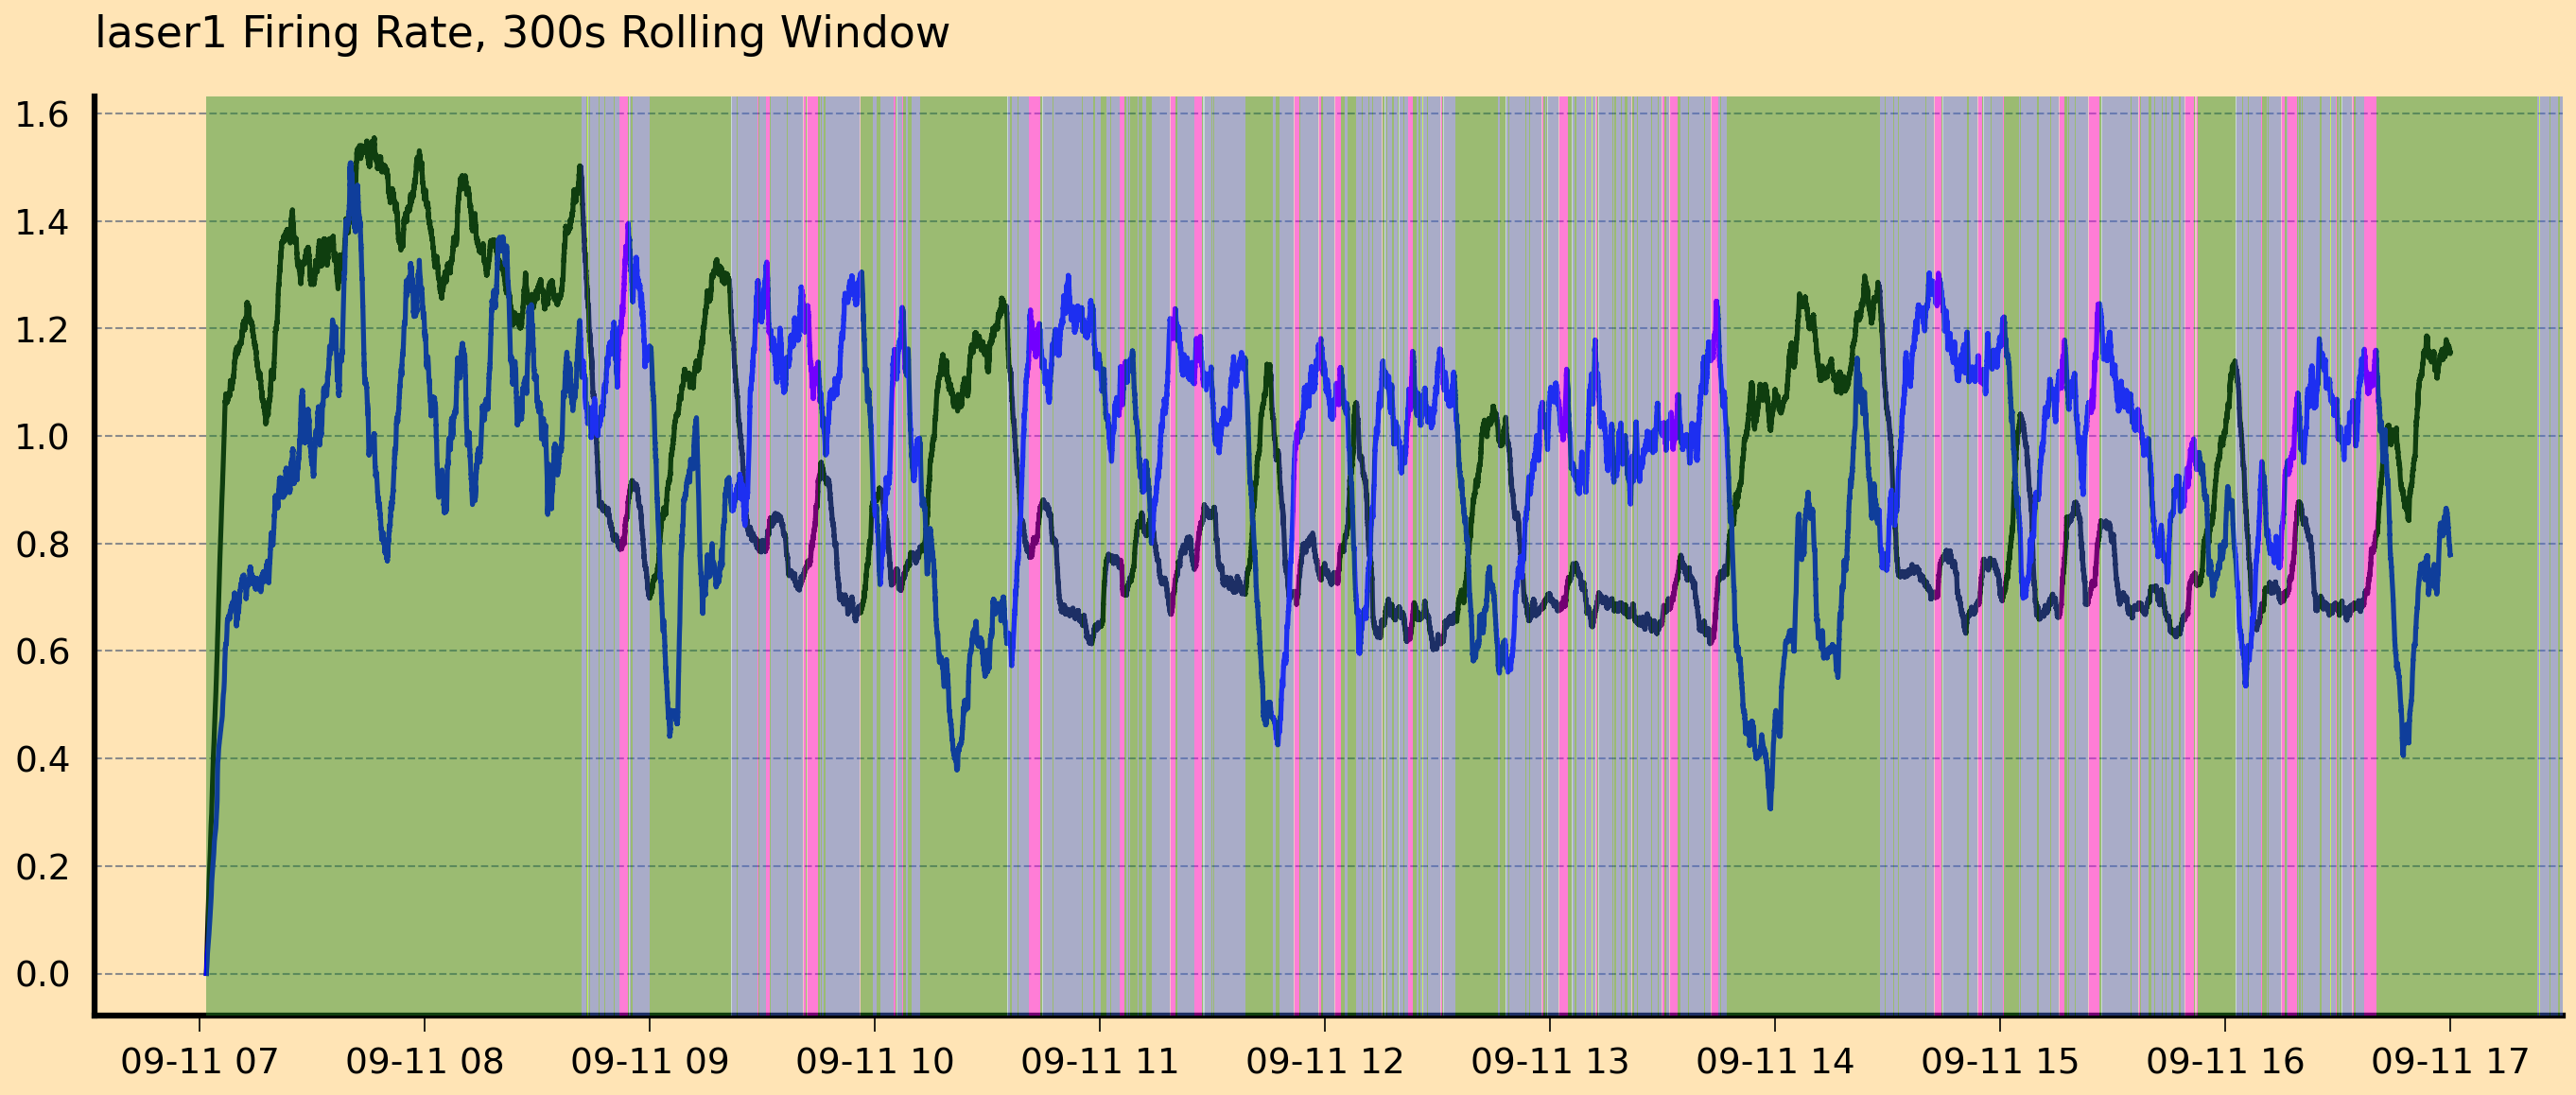

In [37]:
pm = d['lr'].udf.rec('laser1-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
om = d['lo'].udf.rec('laser1-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-09-11 07:00:00'
t2 = '2022-09-11 17:00:00'
pdata = d['lr'].udf.ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/pm
odata = d['lo'].udf.ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(d['lr'].udf.ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(d['lo'].udf.ts(t1, t2).datetime.values, odata, color='blue')

#stim_borders = d['lo'].udf.stim().datetime.values.min(), d['lo'].udf.stim().datetime.values.max()
#ax.axvspan(stim_borders[0], stim_borders[1], color='skyblue', alpha=0.5)

ax.set_title('laser1 Firing Rate, 300s Rolling Window')
kx.plots.shade_hypno_for_me(hyp['laser1-bl'], ax)

<AxesSubplot:title={'left':'laser1 Firing Rate, 300s Rolling Window'}>

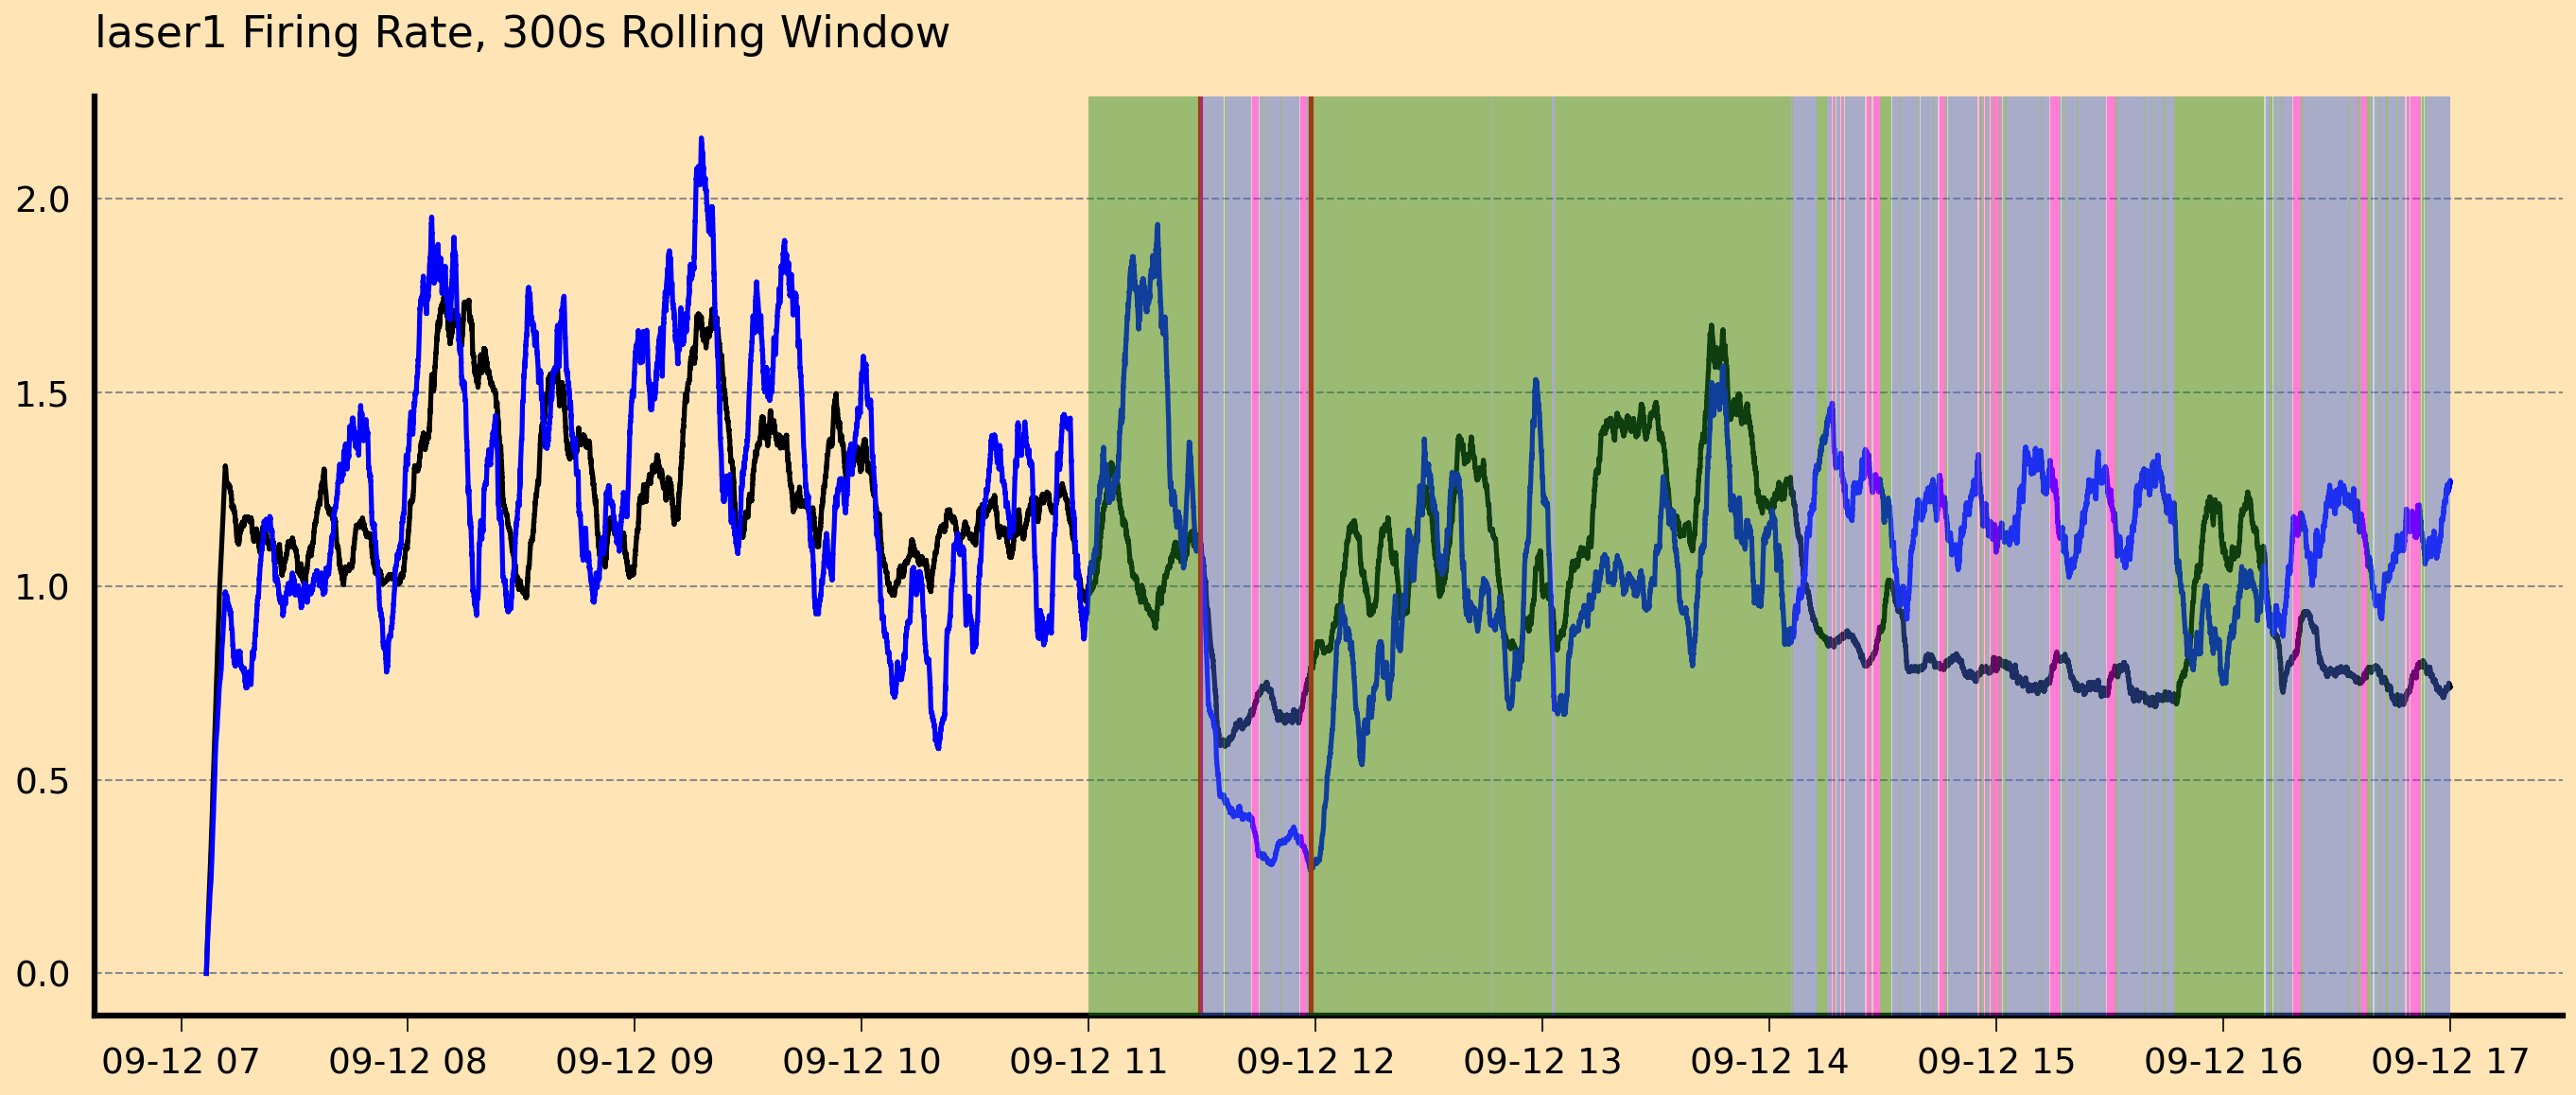

In [40]:
pm = d['lr'].udf.rec('laser1-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
om = d['lo'].udf.rec('laser1-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-09-12 07:00:00'
t2 = '2022-09-12 17:00:00'
pdata = d['lr'].udf.ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/pm
odata = d['lo'].udf.ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(d['lr'].udf.ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(d['lo'].udf.ts(t1, t2).datetime.values, odata, color='blue')

stim_borders = d['lo'].udf.stim().datetime.values.min(), d['lo'].udf.stim().datetime.values.max()
ax.axvline(stim_borders[0], color='red')
ax.axvline(stim_borders[1], color='red')

ax.set_title('laser1 Firing Rate, 300s Rolling Window')
kx.plots.shade_hypno_for_me(hyp['laser1'], ax)

In [68]:
d['lo'].udf.xn()

AttributeError: 'SpikeAccessor' object has no attribute 'xn'

In [85]:
d['lo'].udf.rec()

TypeError: SpikeAccessor.rec() missing 1 required positional argument: 'rec'

In [64]:
pm = d['lr'].udf.rec('laser1-bl').xn().rolling('300s', on='datetime').count().cluster_id.values.mean()
om = d['lo'].udf.rec('laser1-bl').xn().rolling('300s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-09-11 07:00:00'
t2 = '2022-09-11 17:00:00'
pdata = d['lr'].udf.ts(t1, t2).xn().rolling('300s', on='datetime').count().cluster_id.values/pm
odata = d['lo'].udf.ts(t1, t2).xn().rolling('300s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(d['lr'].udf.ts(t1, t2).xn().datetime.values, pdata, color='k')
ax.plot(d['lo'].udf.ts(t1, t2).xn().datetime.values, odata, color='blue')

#stim_borders = d['lo'].udf.stim().datetime.values.min(), d['lo'].udf.stim().datetime.values.max()
#ax.axvspan(stim_borders[0], stim_borders[1], color='skyblue', alpha=0.5)

ax.set_title('laser1 Firing Rate, 300s Rolling Window, noisy units removed')
kx.plots.shade_hypno_for_me(hyp['laser1-bl'], ax)

AttributeError: 'DataFrame' object has no attribute 'xn'